# Load Data

In [1]:
import sys
import time
import os
import sqlite3
import itertools

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from scipy.stats import nbinom, norm, poisson, geom

import pyhsmm
import pyhsmm.basic.distributions as distributions
from pyhsmm import util
from pyhsmm.util.general import rle
from pyhsmm.util.text import progprint_xrange

import application_utils as aputils

from reportlab.pdfgen import canvas
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch
from reportlab.lib.enums import TA_CENTER
from reportlab.lib.pagesizes import A4

from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import rc

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
%matplotlib inline

In [2]:
conn = sqlite3.connect('../Data/powers_082016.db')
cursor = conn.cursor()
cursor.execute(""" DROP TABLE IF EXISTS devices """)
cursor.execute(""" DROP TABLE IF EXISTS powers """)
cursor.execute(""" DROP TABLE IF EXISTS devices_proportions """)
cursor.execute(""" DROP TABLE IF EXISTS devices_used """)

# we get all the filenames we are going to load 
list_files = os.listdir('../Data/082016')
# we load the powers from all houses
sys.stdout.write('Data loading...\n')
sys.stdout.flush()
# we set some parameters
first_house = True
number_houses = 0

def convert_datatype(datatype):
    # Convert the data type from a dataframe to the data type for a database
    if datatype == "int64":
        datatype = "INTEGER"
    elif datatype == "float64":
        datatype = "DOUBLE"
    else:
        datatype = "DATETIME"
    return datatype

# we load every data file and we insert them in a database
for idx, filename in enumerate(list_files):
    sys.stdout.write("Loading file {0}/{1}                     \r".format(idx+1,len(list_files)))
    sys.stdout.flush()
    # we load data
    data = pd.read_csv("../Data/082016/"+filename)

    # we set the data type to float64 for every device columns
    firstcol = data.columns[3]
    data.loc[:,firstcol:] = data.loc[:,firstcol:].astype(float)

    if first_house:
        # we initialize the tables that will keep all the results
        # Powers table
        list_columns = [name+" "+convert_datatype(datatype) for name, datatype in zip(data.columns,data.dtypes)]
        placeholders= ', '.join(list_columns)
        query= 'CREATE TABLE powers(%s, PRIMARY KEY(localminute,dataid))' % placeholders
        cursor.execute(query)

    # we insert data in the powers table
    sys.stdout.write("Inserting file {0}/{1} in the database\r".format(idx+1,len(list_files)))
    sys.stdout.flush()
    data.to_sql("powers", conn, if_exists="append",index=False)
    
    # we aggregate devices with the same name (for example: we sum lights_plugs1, lights_plugs2, lights_plugs3 etc...)
    # because we'll use the same models for devices with the same name as they should behave similarly
    # so we need the aggregate values to compute proportions and usage to then choose the devices and the houses
    for k in ['6','5','4','3','2']:
        for name in [x.split(k)[0] for x in data.columns if k in x]:
            data[name] = 0.
            for e in range(int(k)):
                name_num = name+str(e+1)
                data[name] += data[name_num]
                del data[name_num]
    # we get rid of the 1 in the devices names
    data.rename(columns=lambda x: x.split('1')[0], inplace=True)
    
    firstcol = data.columns[3]
    
    if first_house:
        # we get the list of the devices
        list_devices = data.columns[3:].tolist()
    
        # we initialize the tables that will keep all the results
        # Devices table
        devices = pd.DataFrame(list_devices,columns=["device_name"])
        devices.to_sql("devices", conn, if_exists="replace",index_label="device_id",schema="""
        CREATE TABLE devices(
             device_id INTEGER PRIMARY KEY,
             device_name TEXT
        )
        """)
    
        # Devices_proportions table
        cursor.execute("""
        CREATE TABLE devices_proportions(
             prop_id INTEGER PRIMARY KEY,
             house_id INTEGER,
             device_id INTEGER,
             proportion DOUBLE,
             FOREIGN KEY(house_id) REFERENCES powers(dataid),
             FOREIGN KEY(device_id) REFERENCES devices(device_id)
        )
        """)
        
        # Devices_used table
        placeholders= ' BOOLEAN, '.join(list_devices)+" BOOLEAN"
        query= 'CREATE TABLE devices_used(house_id INTEGER PRIMARY KEY, %s, FOREIGN KEY(house_id) REFERENCES powers(dataid))' % placeholders
        cursor.execute(query)
        conn.commit()
        first_house = False
    
    # we compute the devices proportions, insert them in the devices_proportions table and insert the devices used
    list_houses = data['dataid'].unique().tolist()
    number_houses += len(list_houses)
    for e, house_id in enumerate(list_houses):
        total_power = data.loc[data.dataid==house_id,'use'].values.sum()
        if total_power == 0.:
            size = np.zeros(len(list_devices))
        else:
            size = data.loc[data.dataid==house_id,firstcol:].values.sum(0)/total_power
        proportions = [(house_id, 
                        devices_id, 
                        prop) for prop, devices_id in zip(np.sort(size)[::-1],np.argsort(size)[::-1])]
        cursor.executemany("""INSERT INTO devices_proportions(house_id, device_id, proportion) VALUES(?, ?, ?)""", proportions)
        size_supzero = size > 0.
        devices_used = pd.DataFrame(data=size_supzero.reshape(1,len(list_devices)),index=[house_id],columns=list_devices)
        devices_used.to_sql("devices_used", conn, if_exists="append",index_label="house_id")
        conn.commit()
        
    sys.stdout.write("File {0}/{1} inserted in the database  \r".format(idx+1,len(list_files)))
    sys.stdout.flush()

conn.close()

sys.stdout.write('\nData loaded: '+str(len(list_files))+' files, '+str(number_houses)+' houses   \n')

Data loading...
File 10/10 inserted in the databasee   
Data loaded: 10 files, 98 houses   


# Choose devices

We compute orders of the devices based on differents criterias. The goal is to choose the best devices to use in our model so that the latter is as robust as possible

In [15]:
# we count the number of times that a device is used in a house
conn = sqlite3.connect('../Data/powers_082016.db')
cursor = conn.cursor()

sup_zero = pd.read_sql_query("""SELECT device_name, count(*) as nb_devices FROM devices as d, devices_proportions as dp 
                        WHERE d.device_id = dp.device_id AND dp.proportion > 0 GROUP BY dp.device_id""", 
                         conn, index_col="device_name")

conn.close()

sup_zero.sort_values("nb_devices", ascending=False)

,nb_devices
device_name,
air,87
furnace,72
refrigerator,66
dishwasher,57
microwave,45
kitchenapp,44
drye,44
clotheswasher,43
oven,31


In [16]:
# we count the number of times that a device is in the cumsum threshold
conn = sqlite3.connect('../Data/powers_082016.db')
cursor = conn.cursor()

threshold = 0.9
sum_sup_thresh = pd.read_sql_query("""
WITH prop_cumsum AS (SELECT d.device_name, dp.device_id, dp.house_id, dp.proportion,
(SELECT sum(dp2.proportion) FROM devices_proportions as dp2 WHERE dp2.prop_id <= dp.prop_id AND dp2.house_id = dp.house_id) as cumsum
FROM devices as d, devices_proportions as dp
WHERE d.device_id = dp.device_id ORDER BY dp.prop_id)
SELECT pc.device_name, count(*) as nb_devices
FROM prop_cumsum as pc
WHERE CASE WHEN (SELECT MIN(pc2.cumsum) FROM prop_cumsum as pc2 WHERE pc2.cumsum >= ? AND pc.house_id = pc2.house_id) < 0.99999999 
    THEN pc.cumsum <= (SELECT MIN(pc2.cumsum) FROM prop_cumsum as pc2 WHERE pc2.cumsum >= ? AND pc.house_id = pc2.house_id)
    ELSE pc.proportion > 0. END
GROUP BY pc.device_id
""", conn, index_col="device_name", params=(threshold, threshold))

conn.close()

sum_sup_thresh.sort_values("nb_devices", ascending=False).head(10)

,nb_devices
device_name,
air,87
furnace,72
refrigerator,66
dishwasher,51
drye,42
microwave,42
kitchenapp,40
clotheswasher,39
oven,29


In [17]:
# we sum the proportion for all devices that are in the cumsum threshold
conn = sqlite3.connect('../Data/powers_082016.db')
cursor = conn.cursor()

threshold = 0.9
sum_sup_thresh = pd.read_sql_query("""
WITH prop_cumsum AS (SELECT d.device_name, dp.device_id, dp.house_id, dp.proportion,
(SELECT sum(dp2.proportion) FROM devices_proportions as dp2 WHERE dp2.prop_id <= dp.prop_id AND dp2.house_id = dp.house_id) as cumsum
FROM devices as d, devices_proportions as dp
WHERE d.device_id = dp.device_id ORDER BY dp.prop_id)
SELECT pc.device_name, sum(pc.proportion) as sum_prop
FROM prop_cumsum as pc
WHERE CASE WHEN (SELECT MIN(pc2.cumsum) FROM prop_cumsum as pc2 WHERE pc2.cumsum >= ? AND pc.house_id = pc2.house_id) < 0.99999999 
    THEN pc.cumsum <= (SELECT MIN(pc2.cumsum) FROM prop_cumsum as pc2 WHERE pc2.cumsum >= ? AND pc.house_id = pc2.house_id)
    ELSE pc.proportion > 0. END
GROUP BY pc.device_id
""", conn, index_col="device_name", params=(threshold, threshold))

conn.close()

sum_sup_thresh.sort_values("sum_prop", ascending=False).head(10)

,sum_prop
device_name,
air,40.246902
furnace,7.642418
refrigerator,3.950458
car,1.926167
drye,1.492191
lights_plugs,1.410272
office,1.057465
livingroom,0.986719
waterheater,0.800374


In [18]:
# we count the number of times that a device is used more than a threshold 
conn = sqlite3.connect('../Data/powers_082016.db')
cursor = conn.cursor()

threshold = 0.4
sup_zero = pd.read_sql_query("""SELECT device_name, count(*) as nb_devices FROM devices as d, devices_proportions as dp 
                        WHERE d.device_id = dp.device_id AND dp.proportion > ? GROUP BY dp.device_id""", 
                         conn, index_col="device_name", params=(threshold,))

conn.close()

sup_zero.sort_values("nb_devices", ascending=False)

,nb_devices
device_name,
air,63


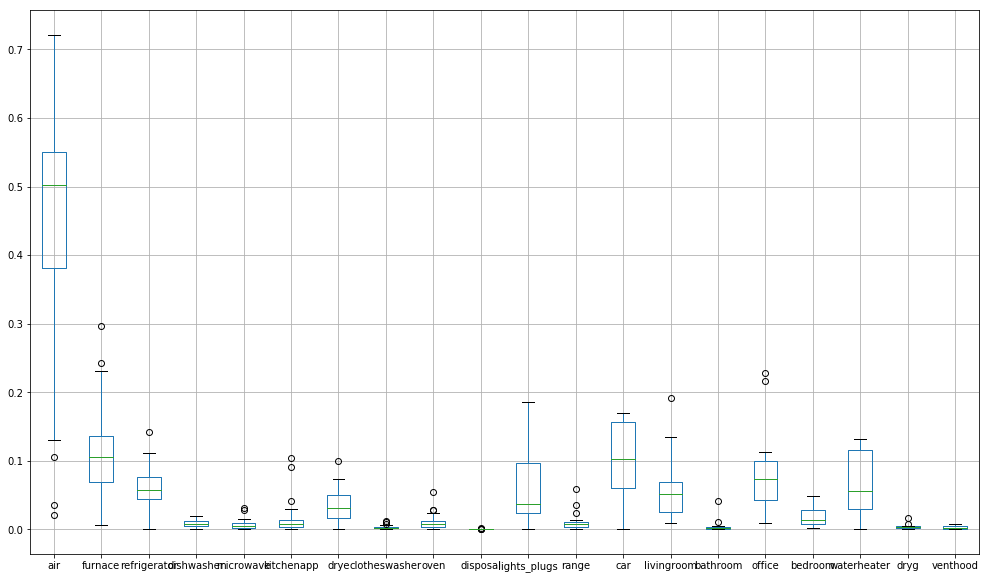

In [19]:
# we plot the boxplot of the proportions for the (number_devices) most used devices and we plot them from the most used (left) to the least used (right)
conn = sqlite3.connect('../Data/powers_082016.db')
cursor = conn.cursor()

number_devices = 20
sup_zero = pd.read_sql_query("""SELECT device_name, count(*) as nb_devices FROM devices as d, devices_proportions as dp 
                        WHERE d.device_id = dp.device_id AND dp.proportion > 0 GROUP BY dp.device_id""", 
                         conn, index_col="device_name")

threshold = sup_zero.sort_values("nb_devices", ascending=False).iloc[number_devices-1,0]
query = """
SELECT d.device_name, dp.house_id, dp.proportion
FROM devices as d, devices_proportions as dp 
WHERE d.device_id = dp.device_id AND dp.proportion > 0. AND dp.device_id IN
(SELECT CASE WHEN count(*) >= %d THEN dp.device_id ELSE NULL END
FROM devices as d, devices_proportions as dp 
WHERE d.device_id = dp.device_id AND dp.proportion > 0.
GROUP BY dp.device_id)
""" % (threshold)
appear_morethan_threshold = pd.read_sql_query(query, conn)

conn.close()

df = pd.DataFrame({col:vals['proportion'] for col,vals in appear_morethan_threshold.groupby('device_name')})
newdf = df[sup_zero.sort_values("nb_devices", ascending=False).index[:number_devices].tolist()]
plt.figure(figsize=(17,10))
newdf.boxplot();

It seems that the best devices to use for our model are air, furnace, refrigerator and dishwasher.

# Choose trainning and testing houses

In [94]:
# we sum the proportions of specified devices for all houses that used (operator) N of these devices
conn = sqlite3.connect('../Data/powers_082016.db')
cursor = conn.cursor()

devices = ['air','furnace','refrigerator','dishwasher']
house_id = 115
#order = "nb_devices DESC, prop DESC"
placeholders = "(du."+'=1 OR du.'.join(devices)+"=1)"
placeholders = placeholders + " AND (d.device_name='"+"' OR d.device_name='".join(devices)+"')"
query = """SELECT du.house_id, dp.proportion as prop, d.device_name
FROM devices_used as du, devices_proportions as dp, devices as d
WHERE du.house_id=dp.house_id AND dp.device_id=d.device_id AND %s AND dp.proportion>0. AND du.house_id=%d 
""" % (placeholders,house_id)
sup_zero = pd.read_sql_query(query, conn)

conn.close()

sup_zero

,house_id,prop,device_name
0,115,0.652834,air
1,115,0.206994,furnace
2,115,0.064256,refrigerator


In [24]:
# we sum the proportions of specified devices for all houses that used (operator) N of these devices
conn = sqlite3.connect('../Data/powers_082016.db')
cursor = conn.cursor()

devices = ['air','furnace','refrigerator','dishwasher']
#devices = ['air','furnace','refrigerator','dishwasher','microwave','kitchenapp','drye','car','lights_plugs', 'oven','office','waterheater']
operator = "="
N = 4
order = "prop DESC" 
#order = "nb_devices DESC, prop DESC"
placeholders = "(du."+'=1 OR du.'.join(devices)+"=1)"
placeholders = placeholders + " AND (d.device_name='"+"' OR d.device_name='".join(devices)+"')"
query = """SELECT du.house_id, sum(dp.proportion) as prop, count(dp.proportion) as nb_devices
FROM devices_used as du, devices_proportions as dp, devices as d
WHERE du.house_id=dp.house_id AND dp.device_id=d.device_id AND %s AND dp.proportion>0.
GROUP BY du.house_id HAVING count(dp.proportion)%s%d ORDER BY %s""" % (placeholders,operator,N,order)
sup_zero = pd.read_sql_query(query, conn)

conn.close()

sup_zero

,house_id,prop,nb_devices
0,946,0.837099,4
1,1551,0.821026,4
2,1830,0.810022,4
3,1463,0.806866,4
4,187,0.803304,4
5,2233,0.785033,4
6,2401,0.784546,4
7,994,0.784375,4
8,2018,0.770353,4
9,503,0.769835,4


From our observations of these queries, we want to build 3 set of houses:
    - AH: houses where all devices (chosen in the previous section) are used and the sum of their proportions is high
    - SH: houses where not all devices are used and the sum of their proportions is high
    - AL: houses where all devices are used and the sum of their proportions is low
Each set contains 10 houses. The houses chosen for each set are the following:
    - AH: 490, 774, 483, 2233, 1830, 994, 2094, 1463, 187, 2361, 2335, 2401, 503, 781, 946 (sum prop >= 0.89)
    - SH: 1791, 1790, 1696, 77, 974 (nb devices <= 3, sum prop >= 0.94)
    - AL: 370, 516 (sum prop <= 0.54) 1086, 624 (sum prop <= 0.68)
Our plan to test our model is to train it on 10 houses from the set AH and test it on all houses from all sets (even the houses used for trainning). The houses chosen for trainning are the following:
    - 490, 483, 1830, 2094, 187, 2335, 2401, 503, 781, 946

# Compute priors

Script to compute priors for a list of houses, devices and number of modes

In [2]:
# we initialize the multi-index data frame that will stock all the estimations for all devices and houses
index = pd.MultiIndex(levels=[[],[],[]],labels=[[],[],[]],names=['device','house_id', 'mode'])
hyperparams_estimations = pd.DataFrame([],index=index,columns=['Obs dist','Obs params','Dur dist','Dur params','Trans dist','Trans params'])

In [2]:
# we load our parameters estimations
hyperparams_estimations = pd.read_table('parameters_estimations.tsv', index_col=[0,1,2])

In [3]:
verbose = 1
#draw = True if verbose == 2 else False
draw = False
#houses_train = [946, 1551, 1463, 187, 2401, 994, 503, 93, 781, 2335, 434, 1415, 483, 490, 1642, 2199, 101, 1403, 545, 1731, 661]
#houses_test = [1830, 2233, 2018, 2171, 2361, 774, 2094, 1632, 114, 26]
#houses_all = houses_train + houses_test
houses_all = [187]
devices = ['air','refrigerator','furnace','dishwasher']
Nb_states_list = [2,3,2,2]
Nb_samples = 25

#rc('text', usetex=True)

for house_id in houses_all:
    print("---------- House {} ----------".format(house_id))
    
    # Log file
    pp = PdfPages("Priors_log/house_{}.pdf".format(house_id))
    
    # we get the data for the house_id
    print("Loading data...")
    conn = sqlite3.connect('../Data/powers_082016.db')
    cursor = conn.cursor()
    query = """SELECT * FROM powers WHERE dataid=%d""" % house_id
    data = pd.read_sql_query(query, conn)
    conn.close()
    
    for (device, Nb_states) in zip(devices,Nb_states_list):
        print("------ Device {}:".format(device))
        
        # we get all the columns (non equal to 0) associated with the device
        alldevices = [col for col in data.columns if device in col and col[len(device)].isdigit() and data.loc[:,col].sum()>0.]
        # we stock the data for these columns and we change the unit to Watts
        powers = data.loc[:,alldevices]*1000
        # we only get the columns that are useful
        useful_col = [powers.sum(0).argmax()] # currently we only take the one that has the maximal total power but we could keep more columns
        for col in useful_col:   
            ### we select the data
            observations = powers[col].values

            ### we estimate the hidden states sequence with an HDP-HSMM model and non informative priors
            print("Estimating hidden states...")
            #title_text = r"\underline{\textbf{Device: %s}}\medbreak\underline{Hidden states estimation}" % device
            title_text = "Device: %s \nHidden states estimation" % device
            hidden_states = aputils.estimate_hidden_states(observations,Nb_states,Nb_samples,verbose,pp=pp,title_text=title_text)
      
            ### we estimate the priors hyperparams given the hidden states sequence
            print("Estimating priors hyperparams...")
            #title_text = r"\underline{Priors hyperparams estimation}"
            title_text = "Priors hyperparams estimation"
            # we set up the distribution we choose as prior
            dur_distributions=['pnbMixture']*Nb_states
            obs_distributions=['gaussian']*Nb_states
            # we estimate the hyper parameters
            estimations = aputils.estimate_hypparams(observations,hidden_states,dur_distributions,obs_distributions,draw,pp=pp,title_text=title_text)
            # we fill the multi-index data frame that will stock all the estimations for all devices and houses
            for mode_name, mode in estimations.items():
                for dist_name, dist_params in mode.items():
                    if dist_name.startswith('Obs'):
                        hyperparams_estimations.loc[(device,house_id,mode_name),'Obs dist'] = dist_name.split(' ')[1]
                        hyperparams_estimations.set_value((device,house_id,mode_name), 'Obs params', dist_params)
                    elif dist_name.startswith('Dur'):
                        hyperparams_estimations.loc[(device,house_id,mode_name),'Dur dist'] = dist_name.split(' ')[1]
                        hyperparams_estimations.set_value((device,house_id,mode_name), 'Dur params', dist_params)
                    elif dist_name.startswith('Trans'):
                        hyperparams_estimations.loc[(device,house_id,mode_name),'Trans dist'] = dist_name.split(' ')[1]
                        hyperparams_estimations.set_value((device,house_id,mode_name), 'Trans params', dist_params)
            
    pp.close()
    
print("\nScript done")

---------- House 187 ----------
Loading data...
------ Device air:
Estimating hidden states...


/home/ROCQ/dyogene/acadas/anaconda3/envs/hmm/lib/python3.6/site-packages/pyhsmm/basic/distributions.py:144: RuntimeWarning: overflow encountered in exp
  self.mixture_weights_n = np.array([np.sqrt(tausq_n_list[label]/self.sigmasq)*np.exp(0.5*mu_n_list[label]**2/tausq_n_list[label]) for label in np.arange(self.k)])
/home/ROCQ/dyogene/acadas/anaconda3/envs/hmm/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))
/home/ROCQ/dyogene/acadas/anaconda3/envs/hmm/lib/python3.6/site-packages/pyhsmm/internals/hsmm_states.py:92: RuntimeWarning: divide by zero encountered in log
  self._log_trans_matrix = np.log(self.trans_matrix)


.........................  [ 25/25,    0.77sec avg, ETA 0.00 ]

   0.77sec avg, 19.16 total

---------------------------------
Mean absolute error: 210.4705725995036
---------------------------------
Posterior model: 

Observations distributions:
[ScalarGaussianFixedvarMixture(mu=44.9339656980674,weights=[ 0.  1.]), ScalarGaussianFixedvarMixture(mu=2970.5217845230136,weights=[ 0.  1.])]

Durations distributions:
Saving on the log file...
Estimating priors hyperparams...
------ Device refrigerator:
Estimating hidden states...
.........................  [ 25/25,    0.56sec avg, ETA 0.00 ]

   0.56sec avg, 13.92 total

---------------------------------
Mean absolute error: 8.324716828908343
---------------------------------
Posterior model: 

Observations distributions:
[ScalarGaussianFixedvarMixture(mu=131.4723705283601,weights=[ 0.  0.  1.]), ScalarGaussianFixedvarMixture(mu=614.43647855021,weights=[ 0.  0.  1.]), ScalarGaussianFixedvarMixture(mu=5.730249285196657,weights=[ 0.  0.  1.])

In [8]:
class stateToLabel:
    
    def __init__(self,Nb_states):
        self.idxState_list = [-1]*Nb_states
        
    def increment(self,state):
        self.idxState_list[state] += 1
        return self.idxState_list[state]

In [17]:
j= stateToLabel(3)

In [21]:
j.increment(1)

3

In [ ]:
j = stateToLabel(3)

In [8]:
# we save our parameters estimations
hyperparams_estimations.to_csv('parameters_estimations.tsv', sep='\t')

we create the classes

In [49]:
houses_train = [946, 1551, 1463, 187, 2401, 994, 503, 93, 781, 2335, 434, 1415, 483, 490, 1642, 2199, 101, 1403, 545, 1731, 661]
houses_test = [1830, 2233, 2018, 2171, 2361, 774, 2094, 1632, 114, 26]
houses_all = houses_train + houses_test
devices = ['air','refrigerator','furnace','dishwasher']
Nb_states_list = [2,3,2,2]
Nb_devices_classes = [2,2,2,2]
Nb_samples = 25

import ast

# we initialize the multi-index data frame that will stock all the final priors for all devices and classes
final_index = pd.MultiIndex(levels=[[],[],[]],labels=[[],[],[]],names=['device','class', 'mode'])
final_priors = pd.DataFrame([],index=final_index,columns=['Obs dist','Obs params','Dur dist','Dur params'])

hyperparams_estimations.sort_index(inplace=True)

# we create the classes of priors by doing a Kmeans for each device on the matrix of theta_hat (rows: houses, cols: modes)
print("Creating the devices classes...")
Nb_houses = len(houses_all)
houses_classes = pd.DataFrame([],index=houses_all,columns=devices+['house_type'])
for device, Nb_states, Nb_class in zip(devices,Nb_states_list,Nb_devices_classes):
    theta_mat = pd.DataFrame([],index=houses_all,columns=['mode {}'.format(i) for i in range(Nb_states)])
    estimationsByHouses = hyperparams_estimations.loc[device].groupby(level='house_id')
    for i, (house_name, house_estimations) in enumerate(estimationsByHouses):
        theta_mat.loc[house_name,:] = [ast.literal_eval(params)['theta_hat'] for params in house_estimations['Obs params']]
    kmeans = KMeans(n_clusters=Nb_class).fit(theta_mat.loc[houses_train,:])
    houses_classes.loc[houses_train,device] = kmeans.labels_
    houses_classes.loc[houses_test,device] = kmeans.predict(theta_mat.loc[houses_test,:])
houses_classes.loc[houses_train,'house_type'] = 'train'
houses_classes.loc[houses_test,'house_type'] = 'test'

# we aggregate the priors for each device and each class
print("Finalizing priors...")
for device, Nb_states, Nb_class in zip(devices,Nb_states_list,Nb_devices_classes):
    for class_number in range(Nb_class):
        class_name = 'class {}'.format(class_number) 
        class_houses_list = list(houses_classes.index[houses_classes.loc[houses_train,device] == class_number].values)
        for mode in ['mode {}'.format(i) for i in range(Nb_states)]: 
            
            # We create the Obs distributions
            obs_list_dist = hyperparams_estimations.loc[(device, class_houses_list, mode), 'Obs dist'].values
            if all(x == obs_list_dist[0] for x in obs_list_dist):
                final_priors.loc[(device,class_name,mode),'Obs dist'] = obs_list_dist[0]
                # We aggregate the Obs params
                params_values = hyperparams_estimations.loc[(device, class_houses_list, mode), 'Obs params'].values
                params_values = params_values[params_values != np.array(None)]
                params_values = np.array([ast.literal_eval(value) for value in params_values])
                if params_values.size == 0:
                    final_priors.loc[(device,class_name,mode),'Obs params'] = None
                else:
                    params_lists = {}
                    for param_name in params_values[0].keys():
                        params_lists[param_name] = []
                    for params in params_values:
                        for param_name, param_value in params.items():
                            params_lists[param_name].append(param_value)
                    final_priors.set_value((device,class_name,mode),'Obs params',aputils.aggregate_priors(params_lists,obs_list_dist[0]))       
            else:
                final_priors.loc[(device,class_name,mode),'Obs dist'] = 'not define'
                final_priors.loc[(device,class_name,mode),'Obs params'] = None
            
            # We create the Dur distributions
            dur_list_dist = hyperparams_estimations.loc[(device, class_houses_list, mode), 'Dur dist'].values
            if all(x == dur_list_dist[0] for x in dur_list_dist):
                final_priors.loc[(device,class_name,mode),'Dur dist'] = dur_list_dist[0]
                # We aggregate the Obs params
                params_values = hyperparams_estimations.loc[(device, class_houses_list, mode), 'Dur params'].values
                params_values = params_values[params_values != np.array(None)]
                params_values = np.array([ast.literal_eval(value) for value in params_values])
                if params_values.size == 0:
                    final_priors.loc[(device,class_name,mode),'Dur params'] = None
                else:
                    params_lists = {}
                    for param_name in params_values[0].keys():
                        params_lists[param_name] = []
                    for params in params_values:
                        for param_name, param_value in params.items():
                            params_lists[param_name].append(param_value)
                    final_priors.set_value((device,class_name,mode),'Dur params',aputils.aggregate_priors(params_lists,dur_list_dist[0]))       
            else:
                final_priors.loc[(device,class_name,mode),'Dur dist'] = 'not define'
                final_priors.loc[(device,class_name,mode),'Dur params'] = None
      
    
print("Prior learning done.")

Creating the devices classes...
Finalizing priors...


/home/ROCQ/dyogene/acadas/anaconda3/envs/hmm/lib/python3.6/site-packages/pandas/core/indexes/base.py:1650: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 31 but corresponding boolean dimension is 21
  result = getitem(key)
/home/ROCQ/dyogene/acadas/Desktop/Notebooks/application_utils.py:363: RuntimeWarning: divide by zero encountered in double_scalars
  hyperparams['alpha_pi'] = x_bar_pi*((x_bar_pi*(1-x_bar_pi)/v_bar_pi)-1)
/home/ROCQ/dyogene/acadas/Desktop/Notebooks/application_utils.py:364: RuntimeWarning: divide by zero encountered in double_scalars
  hyperparams['beta_pi'] = (1-x_bar_pi)*((x_bar_pi*(1-x_bar_pi)/v_bar_pi)-1)
/home/ROCQ/dyogene/acadas/Desktop/Notebooks/application_utils.py:369: RuntimeWarning: divide by zero encountered in double_scalars
  hyperparams['alpha_nb'] = x_bar_ng*((x_bar_ng*(1-x_bar_ng)/v_bar_ng)-1)
/home/ROCQ/dyogene/acadas/Desktop/Notebooks/application_utils.py:370: RuntimeWarning: divide by zero enco

Prior learning done.


In [3]:
hyperparams_estimations.sort_index(inplace=True)
hyperparams_estimations

Obs dist  \
device       house_id mode               
air          187      mode 0  gaussian   
                      mode 1  gaussian   
             946      mode 0  gaussian   
                      mode 1  gaussian   
             1463     mode 0  gaussian   
                      mode 1  gaussian   
             1551     mode 0  gaussian   
                      mode 1  gaussian   
             2401     mode 0  gaussian   
                      mode 1  gaussian   
dishwasher   187      mode 0  gaussian   
                      mode 1  gaussian   
             946      mode 0  gaussian   
                      mode 1  gaussian   
             1463     mode 0  gaussian   
                      mode 1  gaussian   
             1551     mode 0  gaussian   
                      mode 1  gaussian   
             2401     mode 0  gaussian   
                      mode 1  gaussian   
furnace      187      mode 0  gaussian   
                      mode 1  gaussian   
             946      mode 0  gaussian   
                      mode 1  gaussian   
             1463     mode 0  gaussian   
                      mode 1  gaussian   
             1551     mode 0  gaussian   
                      mode 1  gaussian   
             2401     mode 0  gaussian   
                      mode 1  gaussian   
refrigerator 187      mode 0  gaussian   
                      mode 1  gaussian   
                      mode 2  gaussian   
             946      mode 0  gaussian   
                      mode 1  gaussian   
                      mode 2  gaussian   
             1463     mode 0  gaussian   
                      mode 1  gaussian   
                      mode 2  gaussian   
             1551     mode 0  gaussian   
                      mode 1  gaussian   
                      mode 2  gaussian   
             2401     mode 0  gaussian   
                      mode 1  gaussian   
                      mode 2  gaussian   

                                                                     Obs params  \
device       house_id mode                                                        
air          187      mode 0  {'theta_hat': 44.770282293941598, 'sigmasq': 8...   
                      mode 1  {'theta_hat': 2970.4736630680391, 'sigmasq': 2...   
             946      mode 0  {'theta_hat': 51.981579538525722, 'sigmasq': 8...   
                      mode 1  {'theta_hat': 2310.896364985163, 'sigmasq': 26...   
             1463     mode 0  {'theta_hat': 46.970399429386589, 'sigmasq': 7...   
                      mode 1  {'theta_hat': 2476.5673795413554, 'sigmasq': 1...   
             1551     mode 0  {'theta_hat': 53.18114266030215, 'sigmasq': 40...   
                      mode 1  {'theta_hat': 1172.9419819078948, 'sigmasq': 5...   
             2401     mode 0  {'theta_hat': 3.5313943161634103, 'sigmasq': 2...   
                      mode 1  {'theta_hat': 1061.889335925139, 'sigmasq': 13...   
dishwasher   187      mode 0  {'theta_hat': 7.9039280318637548, 'sigmasq': 2...   
                      mode 1  {'theta_hat': 1023.8502617801047, 'sigmasq': 2...   
             946      mode 0  {'theta_hat': 2.0867299961822634, 'sigmasq': 6...   
                      mode 1  {'theta_hat': 1047.9732142857142, 'sigmasq': 4...   
             1463     mode 0  {'theta_hat': 0.81121163020973985, 'sigmasq': ...   
                      mode 1  {'theta_hat': 829.0585365853658, 'sigmasq': 79...   
             1551     mode 0  {'theta_hat': 2.4086406411815031, 'sigmasq': 2...   
                      mode 1  {'theta_hat': 757.36322869955154, 'sigmasq': 6...   
             2401     mode 0  {'theta_hat': 0.83738885762521098, 'sigmasq': ...   
                      mode 1  {'theta_hat': 686.5, 'sigmasq': 6066.203703703...   
furnace      187      mode 0  {'theta_hat': 529.35213170113968, 'sigmasq': 2...   
                      mode 1  {'theta_hat': 653.02968832036652, 'sigmasq': 4...   
             946      mode 0  {'theta_hat': 16.488271981560572,

In [7]:
hyperparams_estimations.loc[('air',946,'mode 1'),'Dur params']

"{'pi_hat': 0.96484733531608491, 'lambda_hat': 8.9837611706442821, 'r_hat': 3.8224379182291237, 'p_hat': 0.94366242810968926}"

In [17]:
# we load our classes
houses_classes = pd.read_table('houses_classes.tsv', index_col=[0])

In [18]:
houses_classes.sort_index(inplace=True)
houses_classes

,air,refrigerator,furnace,dishwasher,house_type
26,1,0,0,0,test
93,0,0,1,0,train
101,1,0,0,1,train
114,1,0,0,0,test
187,0,0,1,0,train
434,0,0,0,0,train
483,0,0,1,0,train
490,0,1,1,0,train
503,1,0,0,0,train
545,1,0,1,0,train


In [51]:
houses_classes.to_csv('houses_classes.tsv', sep='\t')

In [52]:
final_priors

Obs dist  \
device       class   mode               
air          class 0 mode 0  gaussian   
                     mode 1  gaussian   
             class 1 mode 0  gaussian   
                     mode 1  gaussian   
refrigerator class 0 mode 0  gaussian   
                     mode 1  gaussian   
                     mode 2  gaussian   
             class 1 mode 0  gaussian   
                     mode 1  gaussian   
                     mode 2  gaussian   
furnace      class 0 mode 0  gaussian   
                     mode 1  gaussian   
             class 1 mode 0  gaussian   
                     mode 1  gaussian   
dishwasher   class 0 mode 0  gaussian   
                     mode 1  gaussian   
             class 1 mode 0  gaussian   
                     mode 1  gaussian   

                                                                    Obs params  \
device       class   mode                                                        
air          class 0 mode 0  {'mu_0': 48.7491146577, 'tausq_0': 984.2029993...   
                     mode 1  {'mu_0': 3401.7622678, 'tausq_0': 183436.29667...   
             class 1 mode 0  {'mu_0': 50.8877117998, 'tausq_0': 2653.199422...   
                     mode 1  {'mu_0': 1873.05293619, 'tausq_0': 215025.3871...   
refrigerator class 0 mode 0  {'mu_0': 11.0036246409, 'tausq_0': 117.0571552...   
                     mode 1  {'mu_0': 111.97297668, 'tausq_0': 1904.6647425...   
                     mode 2  {'mu_0': 370.877601349, 'tausq_0': 22599.23403...   
             class 1 mode 0  {'mu_0': 52.0377339144, 'tausq_0': 0.0, 'sigma...   
                     mode 1  {'mu_0': 448.728070175, 'tausq_0': 0.0, 'sigma...   
                     mode 2  {'mu_0': 1416.37574769, 'tausq_0': 0.0, 'sigma...   
furnace      class 0 mode 0  {'mu_0': 18.7992474302, 'tausq_0': 115.5073297...   
                     mode 1  {'mu_0': 393.374249544, 'tausq_0': 14215.27668...   
             class 1 mode 0  {'mu_0': 154.946702105, 'tausq_0': 43257.90346...   
                     mode 1  {'mu_0': 767.483507897, 'tausq_0': 10151.96753...   
dishwasher   class 0 mode 0  {'mu_0': 2.48349494023, 'tausq_0': 3.531436980...   
                     mode 1  {'mu_0': 904.071992659, 'tausq_0': 24174.52251...   
             class 1 mode 0  {'mu_0': 0.00363824196555, 'tausq_0': 0.0, 'si...   
                     mode 1  {'mu_0': 2.44736842105, 'tausq_0': 0.0, 'sigma...   

                               Dur dist  \
device       class   mode                 
air          class 0 mode 0  pnbMixture   
                     mode 1  pnbMixture   
             class 1 mode 0  pnbMixture   
                     mode 1  pnbMixture   
refrigerator class 0 mode 0  pnbMixture   
                     mode 1  pnbMixture   
                     mode 2  pnbMixture   
             class 1 mode 0  pnbMixture   
                     mode 1  pnbMixture   
                     mode 2  pnbMixture   
furnace      class 0 mode 0  pnbMixture   
                     mode 1  pnbMixture   
             class 1 mode 0  pnbMixture   
                     mode 1  pnbMixture   
dishwasher   class 0 mode 0  pnbMixture   
                     mode 1  pnbMixture   
             class 1 mode 0  pnbMixture   
                     mode 1  pnbMixture   

                                                                    Dur params  
device       class   mode                                                       
air          class 0 mode 0  {'alpha_pi': 46.0697235522, 'beta_pi': 6.88859...  
                     mode 1  {'alpha_pi': 94.5295502615, 'beta_pi': 11.4048...  
             class 1 mode 0  {'alpha_pi': 1.00084295222, 'beta_pi': 0.17688...  
                     mode 1  {'alpha_pi': 10.2518784904, 'beta_pi': 1.09992...  
refrigerator class 0 mode 0  {'alpha_pi': 2.54051794199, 'beta_pi': 0.48267...  
                     mode 1  {'alpha_pi': 1.11779324808, 'beta_pi': 0.61351...  
                     mode 2  {'alpha_pi': 2.22686220613, '

In [310]:
def print_dict(dictionary,nb_tabs=0):
    if dictionary is None:
        tabs = '\t'*nb_tabs
        print(tabs+"None")
        return
    for key, value in dictionary.items():
        tabs = '\t'*nb_tabs
        if isinstance(value, dict):
            print(tabs+'{0}: '.format(key))
            print_dict(value,nb_tabs+1)
        else:
            print(tabs+'{0}: {1}'.format(key,value))
            
def print_multiIndex_Df(df):
    for i in df.index.get_level_values(df.index.names[0]).unique():
        print('\t'+i+': ')
        for j in df.loc[(i,slice(None),slice(None))].index.get_level_values(df.index.names[1]).unique():
            print('\t\t'+j+': ')
            for k in df.loc[(i,j,slice(None))].index.get_level_values(df.index.names[2]).unique():
                print('\t\t\t'+k+': ')
                print('\t\t\t\tObs {}'.format(df.loc[(i,j,k),'Obs dist'])+': ')
                print_dict(df.loc[(i,j,k),'Obs params'],5)
            
                print('\t\t\t\tDur {}'.format(df.loc[(i,j,k),'Dur dist'])+': ')
                print_dict(df.loc[(i,j,k),'Dur params'],5)

In [311]:
print_multiIndex_Df(final_priors)

	air: 
		class 0: 
			mode 0: 
				Obs gaussian: 
					mu_0: 88.44550953864594
					tausq_0: 167.41576329704395
					sigmasq: 172249.61158981457
				Dur nbinom: 
					r: 0.8465877726400025
					alpha_0: 35.64568900513701
					beta_0: 1.729948360625512
			mode 1: 
				Obs gaussian: 
					mu_0: 2523.145120571963
					tausq_0: 104768.17049084902
					sigmasq: 490681.62520058267
				Dur nbinom: 
					r: 1.2771946176746911
					alpha_0: 11.561597886643249
					beta_0: 1.9480676464909201
			mode 2: 
				Obs gaussian: 
					mu_0: 3147.6429290579495
					tausq_0: 241704.27418374995
					sigmasq: 181366.59443097006
				Dur nbinom: 
					r: 0.496605958457263
					alpha_0: 8.985319535621528
					beta_0: 0.47843635613689195
		class 1: 
			mode 0: 
				Obs gaussian: 
					mu_0: 14.582042072857876
					tausq_0: 0.0
					sigmasq: 32121.748964326598
				Dur nbinom: 
					r: 0.4104503454386321
					alpha_0: inf
					beta_0: inf
			mode 1: 
				Obs gaussian: 
					mu_0: 78.59850543478261
					tausq_0: 0

In [53]:
final_priors.to_csv('priors.tsv', sep='\t')

In [54]:
read_priors = pd.read_table('priors.tsv', index_col=[0,1,2])

In [55]:
read_priors

Obs dist  \
device       class   mode               
air          class 0 mode 0  gaussian   
                     mode 1  gaussian   
             class 1 mode 0  gaussian   
                     mode 1  gaussian   
refrigerator class 0 mode 0  gaussian   
                     mode 1  gaussian   
                     mode 2  gaussian   
             class 1 mode 0  gaussian   
                     mode 1  gaussian   
                     mode 2  gaussian   
furnace      class 0 mode 0  gaussian   
                     mode 1  gaussian   
             class 1 mode 0  gaussian   
                     mode 1  gaussian   
dishwasher   class 0 mode 0  gaussian   
                     mode 1  gaussian   
             class 1 mode 0  gaussian   
                     mode 1  gaussian   

                                                                    Obs params  \
device       class   mode                                                        
air          class 0 mode 0  {'mu_0': 48.749114657725947, 'tausq_0': 984.20...   
                     mode 1  {'mu_0': 3401.7622677963004, 'tausq_0': 183436...   
             class 1 mode 0  {'mu_0': 50.887711799790935, 'tausq_0': 2653.1...   
                     mode 1  {'mu_0': 1873.0529361852484, 'tausq_0': 215025...   
refrigerator class 0 mode 0  {'mu_0': 11.003624640937971, 'tausq_0': 117.05...   
                     mode 1  {'mu_0': 111.97297668021551, 'tausq_0': 1904.6...   
                     mode 2  {'mu_0': 370.8776013487041, 'tausq_0': 22599.2...   
             class 1 mode 0  {'mu_0': 52.037733914380929, 'tausq_0': 0.0, '...   
                     mode 1  {'mu_0': 448.72807017543857, 'tausq_0': 0.0, '...   
                     mode 2  {'mu_0': 1416.3757476889614, 'tausq_0': 0.0, '...   
furnace      class 0 mode 0  {'mu_0': 18.799247430169071, 'tausq_0': 115.50...   
                     mode 1  {'mu_0': 393.37424954388678, 'tausq_0': 14215....   
             class 1 mode 0  {'mu_0': 154.94670210526257, 'tausq_0': 43257....   
                     mode 1  {'mu_0': 767.48350789712515, 'tausq_0': 10151....   
dishwasher   class 0 mode 0  {'mu_0': 2.4834949402285185, 'tausq_0': 3.5314...   
                     mode 1  {'mu_0': 904.07199265887357, 'tausq_0': 24174....   
             class 1 mode 0  {'mu_0': 0.0036382419655489927, 'tausq_0': 0.0...   
                     mode 1  {'mu_0': 2.4473684210526314, 'tausq_0': 0.0, '...   

                               Dur dist  \
device       class   mode                 
air          class 0 mode 0  pnbMixture   
                     mode 1  pnbMixture   
             class 1 mode 0  pnbMixture   
                     mode 1  pnbMixture   
refrigerator class 0 mode 0  pnbMixture   
                     mode 1  pnbMixture   
                     mode 2  pnbMixture   
             class 1 mode 0  pnbMixture   
                     mode 1  pnbMixture   
                     mode 2  pnbMixture   
furnace      class 0 mode 0  pnbMixture   
                     mode 1  pnbMixture   
             class 1 mode 0  pnbMixture   
                     mode 1  pnbMixture   
dishwasher   class 0 mode 0  pnbMixture   
                     mode 1  pnbMixture   
             class 1 mode 0  pnbMixture   
                     mode 1  pnbMixture   

                                                                    Dur params  
device       class   mode                                                       
air          class 0 mode 0  {'alpha_pi': 46.069723552177628, 'beta_pi': 6....  
                     mode 1  {'alpha_pi': 94.529550261459661, 'beta_pi': 11...  
             class 1 mode 0  {'alpha_pi': 1.0008429522197928, 'beta_pi': 0....  
                     mode 1  {'alpha_pi': 10.251878490370444, 'beta_pi': 1....  
refrigerator class 0 mode 0  {'alpha_pi': 2.5405179419854691, 'beta_pi': 0....  
                     mode 1  {'alpha_pi': 1.1177932480833208, 'beta_pi': 0....  
                     mode 2  {'alpha_pi': 2.22686220613425